# Histopathologic Cancer Detection - Prediction Testing

In this notebook, we load our previously trained model (you can view the other notebook for more information on that) and test it on some images and then visualize the result. 

**Sliding Window Algorithm**

We implement a sliding window algorithm (since the model is trained on 96x96 pixel-size images) in order to identify cancer in each region of the scan by running through the model which is trained on such scans.

**Connected Component Labeling**

We then run a Connected-Component Labeling algorithm that will idetify the connected regions in which cancer exists and label them accordingly (it gives a distinct label to each connected region). 

**Visualize Results**

Finally, we use the labeling in order to visualize them for the diagnosis. This done in two different ways in order to give the doctor helpful insight on where the damaged tissues might be:

 - Use the labels to get bounding boxes for each region, that we display accordingly.
 - Overlay the resulting regions and mark the labelled ones with a distinct color to give the precise locations of where the cancer tissue is most likely at.


# 1. Loding the necessary libraries

This cell is for running on Google Colab, which necessitates TensorFlow version 1.x (1.5 usually) in order to avoid bugs. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam


def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top=False, weights=None, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

Using TensorFlow backend.


In [0]:
import argparse 
import cv2
import numpy as np
import os
from keras.applications.nasnet import preprocess_input
import math
import matplotlib.pyplot as plt

In [4]:
#add preprocessing

model = get_model_classif_nasnet()
model.load_weights("best_model.h5")















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
_________________________________________________________________

In [0]:
w_size = 32
image = cv2.imread("test_image1.jpg")

In [0]:
height = image.shape[0]
width = image.shape[1]
windows_x = math.ceil(image.shape[0]/w_size)
windows_y = math.ceil(image.shape[1]/w_size)
preds = np.zeros((windows_x, windows_y))

In [0]:
# create padded image so prediction can be done on the whole original image with the 
# sliding window method
padded_image = np.pad(image, pad_width=((w_size, w_size), (w_size, w_size), (0, 0)), mode='symmetric')

X = np.ndarray((windows_x*windows_y, 96, 96, 3))
Y=[]
for x in range(windows_x):
    for y in range(windows_y):
    #x is start of window, x+3 is end (extra mirror window is counted), because window is 3*window size. same for y 
          
        start_x = min(x * w_size, height-96)
        end_x = min((x+3) * w_size, height)
        start_y = min(y * w_size, width-96)
        end_y = min((y+3) * w_size, width)
        cur_im = padded_image[start_x:end_x, start_y:end_y]
        X[x*windows_y + y, :, :, :] = preprocess_input(cur_im)        

In [8]:
X.shape

(884, 96, 96, 3)

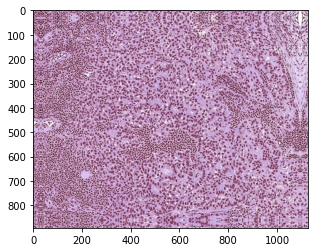

In [9]:
plt.imshow(padded_image)

In [0]:
Y = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()

# Connected components labelling

for x in range(windows_x):
    for y in range(windows_y):
        preds[x, y] = Y[x*windows_y + y]

In [11]:
preds.shape

(26, 34)

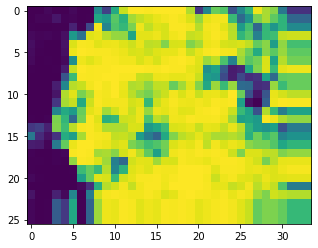

In [28]:
plt.imshow(preds)

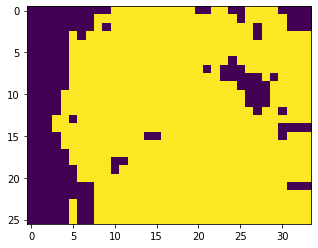

In [34]:
plt.imshow(preds > 0.5)

In [0]:
import queue 

# This code implements the Connected Components Labelling algorithm using the classic method
# The input is the matrix of predictions, the output is labeled component matrix 

def CCL(preds) :

    windows_x = preds.shape[0]
    windows_y = preds.shape[1]  
    
    labels = np.zeros((windows_x, windows_y))
    cur_g = 1
    parent = {} # Dict to store disjoint sets
    
    # first pass
    for x in range(windows_x):
        for y in range(windows_y):
            if preds[x, y] > 0.5 :
                
                # Initializing the labels of the neighboring pixels (the one before and the one above)
                prev_x, prev_y = 0, 0                 
                if x>0 and labels[x-1, y] :
                    prev_x = labels[x-1, y]                    
                if y>0 and labels[x, y-1] :
                    prev_y = labels[x, y-1]   
                      
                # If both of the neighboring pixels aren't labeled    
                if not(prev_x or prev_y) :
                    labels[x, y] = cur_g
                    cur_g+=1
                    
                # If at least one of them is labeled    
                else :
                    # If only one of them is labeled, assign the value of the other one
                    if not prev_x:
                        parent[(x, y-1)] = (x, y)
                        labels[x, y] = prev_y
                    elif not prev_y :
                        parent[(x-1, y)] = (x, y)
                        labels[x, y] = prev_x
                    # If both of them are labeled, assign the minimal value and make the maximum child of the minimum     
                    else :
                        if prev_x >= prev_y :
                            parent[(x-1, y)] = (x, y-1)
                            parent[(x, y-1)] = (x, y)
                            labels[x, y] = prev_y
                        elif prev_y > prev_x :    
                            parent[(x, y-1)] = (x-1, y)
                            parent[(x-1, y)] = (x, y)
                            labels[x, y] = prev_x
                          
                            
    # second pass

    for x in range(windows_x):
        for y in range(windows_y):
            if preds[x, y] > 0.5 and (x, y) in parent : 
                px = (x, y)                
                q = queue.LifoQueue() # essentially a stack

                # Backtrack to the root, saving the pixels in the process
                while px in parent and parent[px] != px :
                    q.put(px)
                    px = parent[px]
                rlabel = labels[px[0], px[1]]  
                
                # Going back, labelling them in the way
                while not q.empty() :
                    px = q.get()
                    labels[px[0], px[1]] = rlabel
                    
    return labels 
                    
# This function will return the labeled boxes from the CCL
def get_labeled_boxes(preds):

    windows_h = preds.shape[0]
    windows_v = preds.shape[1]
    groups = {}

    # We run the program through the labels matrix a last time, getting the min and max x,
    # min and max y to draw bounding box
    for x in range(windows_h):
        for y in range(windows_v):
            if labels[x, y] :
                label = labels[x, y]
                if label in groups:
                    groups[label][0] = min(groups[label][0], x)
                    groups[label][1] = min(groups[label][1], y)
                    groups[label][2] = max(groups[label][2], x)
                    groups[label][3] = max(groups[label][3], y)
                else :
                    groups[label] = [x, y, x, y]

    return groups

In [0]:
labels = CCL(preds)
groups = get_labeled_boxes(labels)

In [32]:
groups

{1.0: [0, 3, 25, 33], 13.0: [23, 5, 25, 5]}

sx : 0, sy : 96, ex : 828, ey : 1064
sx : 736, sy : 160, ex : 828, ey : 192


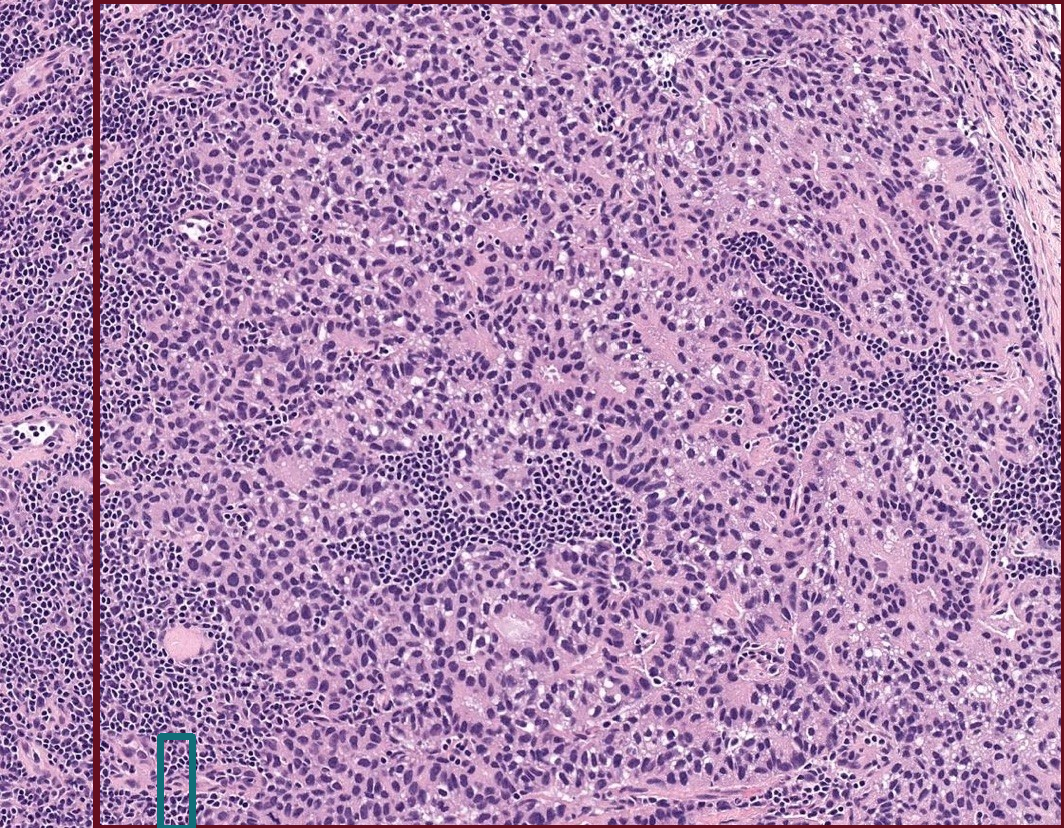

In [35]:
#if you're not running on google colab, you should use cv2.imshow() instead
from google.colab.patches import cv2_imshow 

colors = np.random.uniform(0, 255, size=(len(groups.keys()), 3))
color_dic = {}
for i, k in enumerate(groups.keys()) :
    color_dic[k] = colors[i]

labeled_img = image.copy()

for g, box in groups.items() :
    start_x = min(box[0] * w_size, height - 32)
    end_x = min((box[2]+1) * w_size, height)
    start_y = min(box[1] * w_size, width - 32)
    end_y = min((box[3]+1) * w_size, width)
    print("sx : {}, sy : {}, ex : {}, ey : {}".format(start_x, start_y, end_x, end_y))
    #in cv2 axes are the inversion of what I've used earlier and vice versa 
    cv2.rectangle(labeled_img, (start_y, start_x), (end_y, end_x), color_dic[g], 5)

cv2_imshow(labeled_img)    

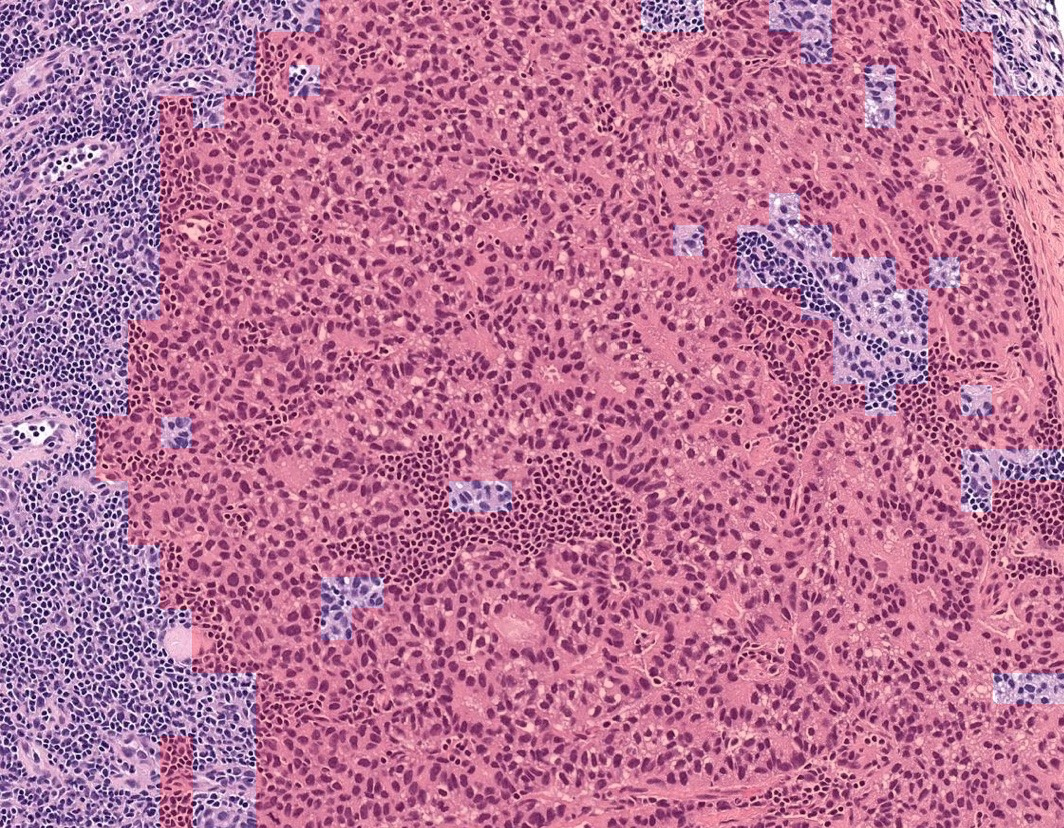

In [23]:
filled_img = image.copy()
overlay = image.copy()
alpha = 0.2

for x in range(windows_x):
    for y in range(windows_y):
        if labels[x, y]:
            start_x = min(x * w_size, height - 32)
            end_x = min((x+1) * w_size, height)
            start_y = min(y * w_size, width - 32)
            end_y = min((y+1) * w_size, width)
            cv2.rectangle(overlay, (start_y, start_x), (end_y, end_x), (0, 0, 255), cv2.FILLED)
cv2.addWeighted(overlay, alpha, filled_img, 1 - alpha, 0, filled_img)
cv2_imshow(filled_img)   

In [39]:
cv2.imwrite("test_image_regions.jpg", labeled_img)
cv2.imwrite("test_image_regions_filled.jpg", filled_img)
cv2.imwrite("test_image_regions_color_filled.jpg", filled_img_colored_regions)

True